In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Reshape
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import util as ut
from shallowNet.shallowNet import shallowNet
import matplotlib.pyplot as plt 
import copy
import matplotlib.cm as cm
from shallowNet.shallowNet import shallowNet

In [2]:
epochs = 20 
batch_size = 5
# generate the trainig set 
print("[INFO] generating trainnig dataset...")
(trainX, trainY) = ut.generate_training_sat(32, 100)

# generate the test set 
print("[INFO] generating testing dataset...")
(testX, testY) = ut.generate_training_sat(32,50)

[INFO] generating trainnig dataset...
[INFO] generating testing dataset...


In [3]:
model = shallowNet.build()
H = model.fit(
    trainY, trainY,
    #validation_data = (testY, testY),
    epochs = epochs,
    batch_size = batch_size,
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                825       
_________________________________________________________________
dense_transpose (DenseTransp (None, 32)                857       
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
20/20 [==============================] - 0s 1ms/step - loss: 0.3083
Epoch 2/20
20/20 [==============================] - 0s 2ms/step - loss: 0.2655
Epoch 3/20
20/20 [==============================] - 0s 2ms/step - loss: 0.2417
Epoch 4/20
20/20 [======

In [4]:
def plot_model_loss(model_fit, path):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epochs), model_fit.history["loss"], label="train_loss")
    #plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Accuracy\n")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(path)
    plt.show()

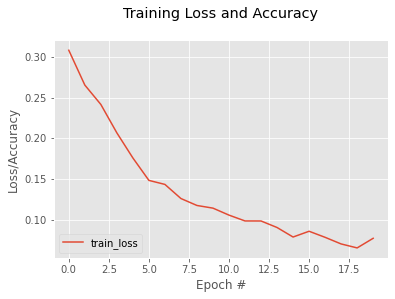

In [5]:
plot_model_loss(H, "loss_plot_model_1.png")

In [6]:
def plot_weights_mode(modelll, path):
    fig, axs = plt.subplots(1,2,constrained_layout=True)
    fig.suptitle('Weights matrix encoder/decoder', fontsize=16)
    fig.subplots_adjust(hspace =0.7)
    pcm = axs[0].imshow(modelll.get_weights()[0], interpolation='nearest', cmap=cm.Greys_r)
    axs[0].set_title("Encoder")
    axs[0].set_ylabel("Visible Node #")
    axs[0].set_xlabel("Hidden Node #")

    pcm=axs[1].imshow(modelll.get_weights()[0], interpolation='nearest', cmap=cm.Greys_r)
    axs[1].set_title("Decoder")
    axs[1].set_ylabel("Visible Node #")
    axs[1].set_xlabel("Hidden Node #")
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(pcm, cax=cbar_ax)
    plt.savefig(path)
    plt.show()

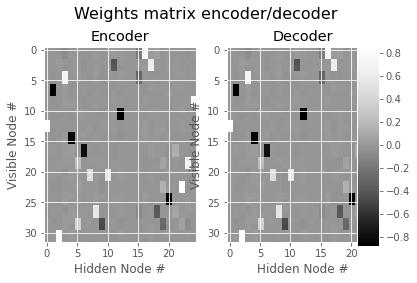

In [7]:
plot_weights_mode(model, "weights_plot_model_1.png")

In [8]:
encoder = tf.keras.Model(inputs = model.input, outputs = [layer.output for layer in model.layers[:3]]) # extract layers from the model and stack them to form an encoder 
features_list_decoder = model.layers[3]# [layer.output for layer in model.layers[3]]
inputs = Input(encoder.layers[-1].output_shape[-1])
features_list_decoder(inputs)
decoder = tf.keras.Model( inputs = inputs ,outputs = features_list_decoder(inputs)) # extract layers from the model and stack them to form an decoder 
encoder.summary()
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                825       
Total params: 825
Trainable params: 825
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
dense_transpose (DenseTransp (None, 32)                857       
Total params: 857
Trainable params: 857
Non-

In [9]:
# apply one bit flip in the latent space
def code_flip_decode(array, encoder, decoder, debuge_variation = False):
    N = np.shape(array)[-1]
    new_array = encoder(tf.expand_dims(array,0))[-1].numpy().flatten() #encode a sample 
    #new_array_binary = np.where(new_array>0, 1, 0) # binarize latent representation 
    index = np.random.randint(np.shape(new_array)[-1]) #choose random index to flip 
    new_array_fliped = copy.copy(new_array) # create copy of the encoded array 
    new_array_fliped[index] = 1-new_array_fliped[index] # apply flip  
    changed_tensor = tf.convert_to_tensor(tf.expand_dims(new_array_fliped,0)) #create new tensor 
    new_tensor = decoder(changed_tensor) # decode the sample with the change from the latent spaece
    output_array = new_tensor.numpy()[-1] # extraxt simple 1D array from tensor 
    output_array_binary = np.where(new_tensor.numpy()[-1]>0.5, 1, 0) # binarize decoded tensor around 0.5
    new_fitness = ut.hiff_fitness(output_array_binary) # calculate transformed tensor fitness
    output_tensor = tf.convert_to_tensor(output_array_binary.reshape((1,N)), dtype = tf.float32) # save output tensor
    if debuge_variation:
        print("Input fitness: ", ut.hiff_fitness(array), ", Decoded fitness: ", ut.hiff_fitness(output_array_binary))
        print("Input: ", array)
        print("Encoded: ", new_array)
        print("Encoded fliped, index: ", index, " : ", new_array_fliped)
        print("Decoded: ", output_array)
        print("Decoder binary: ", output_array_binary, "\n")
    return output_tensor, output_array_binary, new_fitness

In [10]:
# transfer a sample throught the encoder - decoder making random flips in the latent space 
def transfer_sample_latent_flip(array, encoder, decoder):
    N = np.shape(array)[-1]
    current_fitness = ut.hiff_fitness(array)
    for i in range(10 *N):
        output_tensor, output_array, new_fitness = code_flip_decode(array, encoder, decoder)
        if new_fitness >= current_fitness: # compare flip with current  fitness 
            current_fitness = new_fitness
            array = output_array
    return array

In [11]:
# generate training set based on the transfer_sample_latent_flip method, which enhance quality of the samples
def generate_new_training_set(initial_training_set, encoder, decoder):
    
    new_trainig_set = []
    N = np.shape(initial_training_set)[-1]
    normalization_factor = ut.hiff_fitness(np.ones((N,)))

    for array in initial_training_set:
        new_trainig_set.append(transfer_sample_latent_flip(array, encoder, decoder))
    return np.asarray(new_trainig_set, dtype = np.float32)

In [20]:
trainY2 = generate_new_training_set(trainY, encoder, decoder) # generate enhanced training set2

In [22]:
model2 = shallowNet.build() # build model2 based on the enhanced data set: trainY2
H2 = model2.fit(
    trainY2, trainY2, 
    epochs = epochs, 
    batch_size = batch_size,
    verbose = 1,
    shuffle = True
)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                825       
_________________________________________________________________
dense_transpose_3 (DenseTran (None, 32)                857       
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
20/20 [==============================] - 0s 1ms/step - loss: 0.2607
Epoch 2/20
20/20 [==============================] - 0s 2ms/step - loss: 0.1747
Epoch 3/20
20/20 [==============================] - 0s 2ms/step - loss: 0.1268
Epoch 4/20
20/20 [====

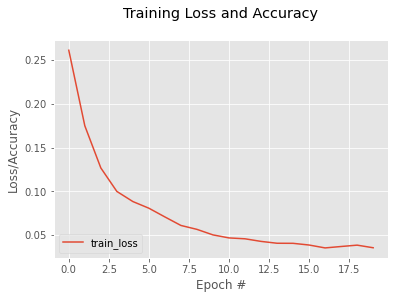

In [23]:
plot_model_loss(H2, "loss_plot_model_2.png")


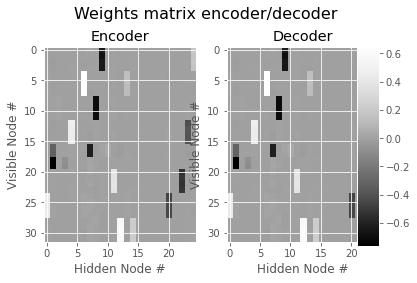

In [24]:
plot_weights_mode(model2, "weights_plot_model_2.png")

In [25]:
def generate_evolution_plot(encoder, decoder, array, path = "solution_development_model_2.png", learning_steps = 50):
    N = np.shape(array)[-1] # size of the array 
    index = np.random.randint(N) #choose random index to flip 
    candidate_solution = array[index]# pick up random sample 
    sol_evol = [] # list to store steps of evolution 
    sol_evol.append(candidate_solution)
    current_fittnes = ut.hiff_fitness(candidate_solution)
    print(candidate_solution)
    for i in range(learning_steps-1):
        new_candidate_sol = copy.copy(candidate_solution)
        output_tensor, output_array, new_fitness = code_flip_decode(new_candidate_sol, encoder, decoder)
        if new_fitness >= current_fittnes:
            candidate_solution = output_array 
            current_fittnes = new_fitness
        sol_evol.append(candidate_solution)

    tmp = np.array(sol_evol)
    plt.figure()
    plt.imshow(tmp, interpolation='nearest', cmap=cm.Greys_r)
    plt.title("Solution Development at Evolution Step 1")
    plt.xlabel("Solution variable")
    plt.ylabel("Development Step")
    plt.colorbar()
    plt.savefig(path)
    plt.show()


[1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1.]


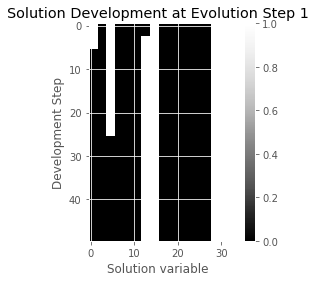

In [26]:
generate_evolution_plot(encoder, decoder, trainY)

In [27]:

def generate_trajectory_plot(encoder, decoder, array, target_size = 10 ,path = "trajectory_model_2.png", learning_steps = 30):    
    X = np.arange(learning_steps)
    normalization_factor = ut.hiff_fitness(np.ones((np.shape(array)[-1],)))
    trajectory_samples = []
    plt.figure()
    plt.title("Example Solution Trajectory 2 at Evolution Step 1")
    for k in range(target_size):
        current_array = array[k]
        current_fitness = ut.hiff_fitness(current_array)
        current_target_trajectory = []
        current_target_trajectory.append(current_fitness/normalization_factor)
        for i in range(learning_steps-1):
            output_tensor, output_array, new_fitness = code_flip_decode(current_array, encoder, decoder)
            if new_fitness >= current_fitness:
                current_fitness = new_fitness
                current_array = output_array
                current_target_trajectory.append(new_fitness/normalization_factor)
            else:
                current_target_trajectory.append(current_target_trajectory[-1])
        trajectory_samples.append(current_target_trajectory)
        plt.plot(X, np.asarray(current_target_trajectory))
    plt.xlabel("learning step")
    plt.ylabel("fitness \ max_fitness")
    plt.savefig(path)
    return trajectory_samples
    

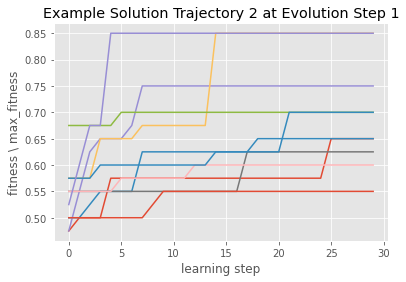

In [28]:
samples = generate_trajectory_plot(encoder, decoder, trainY)